In [1]:
from itertools import islice
from itertools import count

import matplotlib.pyplot as plt
from freegroup.sampling import freegroup
from freegroup.sampling.helper import get_rng
from freegroup.tools import Comm, flatten, to_string
from tqdm import tqdm


from freegroup.sampling import CFGNormalClosureSampler

from dataclasses import dataclass

In [2]:
@dataclass
class Config:
    fdim: int = 2
    num_pairs: int = 10
    L: int = 50
    N: int = int(1e8)
    seed: int = 0
    closure_max_len: int = 8
    max_attempts: int = 1e4


cfg = Config(N=1e5, num_pairs=1)

In [3]:
def generate_random_closure(rng, fdim, max_length=8):
    length = rng.integers(1, max_length + 1)
    closure = freegroup(fdim=fdim, length=length, rng=rng)
    return closure


def generate_closure_pairs(rng, fdim, num_pairs=5, max_length=8):
    return [
        (
            generate_random_closure(rng, fdim, max_length),
            generate_random_closure(rng, fdim, max_length),
        )
        for _ in range(num_pairs)
    ]


def create_samplers(closure_pairs, fdim):
    samplers = []
    for r, s in tqdm(closure_pairs):
        R_sampler = CFGNormalClosureSampler.build(closure=r, fdim=fdim)
        S_sampler = CFGNormalClosureSampler.build(closure=s, fdim=fdim)
        samplers.append((R_sampler, S_sampler))

    return samplers


def get_whitehead_multilabel(label, num_pairs=None):
    if label.startswith("r"):
        return [int(label[1:])]
    elif label.startswith("s"):
        return [num_pairs + int(label[1:])]
    elif label == "f":
        return []
    elif label == "c":
        return list(range(2 * num_pairs))
    else:
        raise ValueError(f"Unknown label: {label}")


def limited_unique_generator(fn, max_attempts, L, L_increment=10):
    seen = set()
    attempt = 0
    while True:
        if attempt == max_attempts:
            L += L_increment
            attempt = 0
            print(f"max_attempts reached. Increasing L to {L}")
        else:
            item = fn(L)
            if item is not None:
                word = item["word_str"]
                if word not in seen:
                    seen.add(word)
                    attempt = 0
                    yield item
                else:
                    attempt += 1
            else:
                attempt += 1


def sample(n_samples, rng, sampler, L, num_pairs, label, max_attempts=1e5):
    def fn(L):
        length = rng.integers(1, L + 1)
        try:
            word = sampler(length=length, rng=rng)
            return {
                "label": label,
                "multilabel": get_whitehead_multilabel(label, num_pairs),
                "word_str": to_string(word),
            }
        except:
            return None

    iterator = limited_unique_generator(fn, max_attempts, L)
    return list(tqdm(islice(iterator, n_samples), total=int(n_samples)))


def sample_freegroup(n_samples, rng, L, label="f", max_attempts=1e5):
    def fn(L):
        length = rng.integers(1, L + 1)
        word = freegroup(2, length, rng=rng)
        return {
            "label": label,
            "multilabel": get_whitehead_multilabel(label),
            "word_str": to_string(word),
        }

    iterator = limited_unique_generator(fn, max_attempts, L)
    return list(tqdm(islice(iterator, n_samples), total=int(n_samples)))


def sample_comm(n_samples, rng, L, num_pairs, samplers=None, label="c", max_attempts=1e4):
    def fn(L):
        words = []
        for R_sampler, S_sampler in samplers:
            for sampler in [R_sampler, S_sampler]:
                flag = False
                while not flag:
                    length = rng.integers(1, L // 5 + 1)
                    try:
                        word = sampler(length=length, rng=rng)
                        words.append(word)
                        flag = True
                    except:
                        pass

        if len(words) < 2:
            return None

        i, j = rng.choice(len(words), size=2, replace=False)
        word1, word2 = words[i], words[j]

        coin = rng.integers(low=0, high=2)
        if coin:
            result = flatten(Comm([word1, word2]))
        else:
            result = flatten(Comm([word2, word1]))

        return {
            "label": label,
            "multilabel": get_whitehead_multilabel(label, num_pairs),
            "word_str": to_string(result),
        }

    iterator = limited_unique_generator(fn, max_attempts, L)
    return list(tqdm(islice(iterator, n_samples), total=int(n_samples)))

In [4]:
rng = get_rng(cfg.seed)

print("Generating pairs...")
closure_pairs = generate_closure_pairs(rng, cfg.fdim, cfg.num_pairs, cfg.closure_max_len)
print(closure_pairs)

print("Creating samplers...")
samplers = create_samplers(closure_pairs, cfg.fdim)

dataset = []
words_per_sampler = int(cfg.N // (4 * cfg.num_pairs))
i = 0
R, S = samplers[i]

print("Generating data...")
for i, (R, S) in enumerate(samplers):
    dataset += sample(words_per_sampler, rng, R, cfg.L, cfg.num_pairs, f"r{i}", cfg.max_attempts)
    dataset += sample(words_per_sampler, rng, S, cfg.L, cfg.num_pairs, f"s{i}", cfg.max_attempts)

dataset += sample_freegroup(int(cfg.N // 4), rng, cfg.L, max_attempts=cfg.max_attempts)
dataset += sample_comm(
    int(cfg.N // 4), rng, cfg.L, cfg.num_pairs, samplers=samplers, max_attempts=cfg.max_attempts
)

Generating pairs...
[([1, -2, -1, -1, 2, 2, 1], [1, 1, 2, 2, -1, 2, -1, 2])]
Creating samplers...


100% 1/1 [00:03<00:00,  3.64s/it]


Generating data...


100% 25000/25000 [00:21<00:00, 1164.00it/s]
100% 25000/25000 [00:22<00:00, 1101.66it/s]
100% 25000/25000 [00:06<00:00, 3760.31it/s]
 16% 4116/25000 [00:23<16:33, 21.02it/s]  

max_attempts reached. Increasing L to 60


100% 25000/25000 [01:05<00:00, 382.58it/s]


# Tokenizer

In [5]:
from tokenizers import Tokenizer
from tokenizers import pre_tokenizers, models, processors, trainers
from transformers import PreTrainedTokenizerFast


def build_bpe_tokenizer(
    words: list,
    vocab_size: int = 1000,
    min_frequency: int = 2,
    add_prompt_tokens: bool = True,
    add_post_processor: bool = True,
):
    tokenizer = Tokenizer(models.BPE(unk_token="<unk>"))
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

    special_tokens = ["<pad>", "<s>", "</s>", "<unk>"]
    if add_prompt_tokens:
        special_tokens.extend(["y", "n", ":"])

    trainer = trainers.BpeTrainer(
        vocab_size=vocab_size,
        min_frequency=min_frequency,
        special_tokens=special_tokens,
    )

    tokenizer.train_from_iterator(words, trainer=trainer)

    if add_post_processor:
        tokenizer.post_processor = processors.TemplateProcessing(
            single="<s> $A </s>",
            special_tokens=[
                ("<s>", tokenizer.token_to_id("<s>")),
                ("</s>", tokenizer.token_to_id("</s>")),
            ],
        )

    tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tokenizer,
        bos_token="<s>",
        eos_token="</s>",
        unk_token="<unk>",
        pad_token="<pad>",
    )

    if add_prompt_tokens:
        tokenizer.add_special_tokens({"additional_special_tokens": ["y", "n", ":"]})

    return tokenizer

In [6]:
def convert_to_bpe_form(word):
    def convert_number(num):
        abs_num = abs(int(num))
        if abs_num > 26:
            return ""

        if int(num) > 0:
            return chr(96 + abs_num)
        else:
            return chr(64 + abs_num)

    numbers = word.split()
    converted = "".join(convert_number(num) for num in numbers)

    return converted

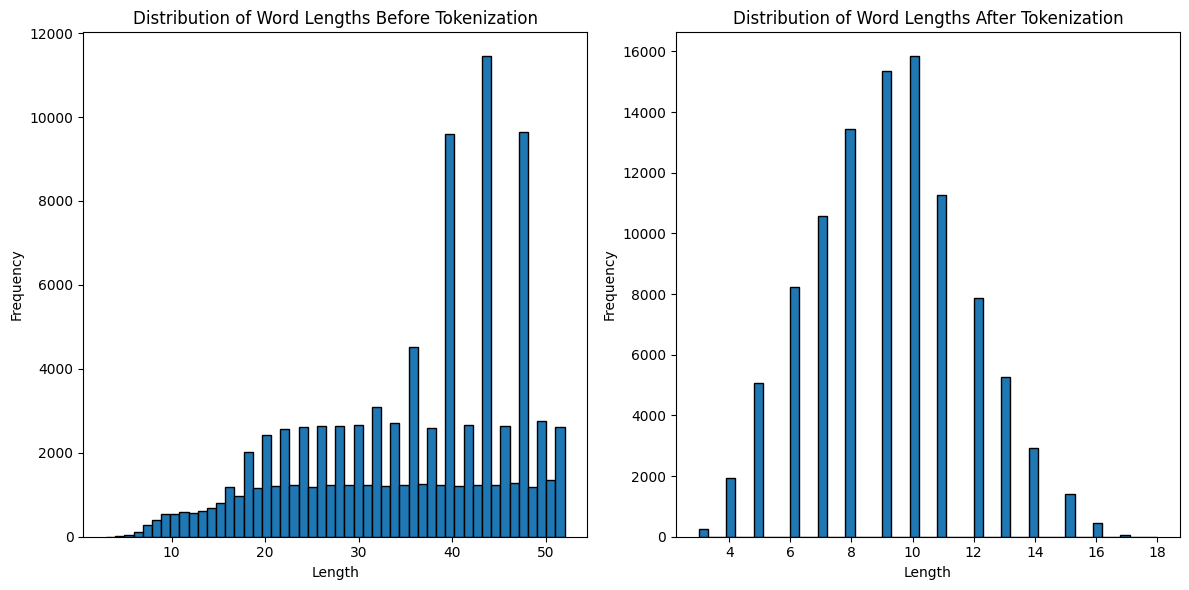

Before tokenization:
  Mean length: 35.63
  Median length: 39.00
  Min length: 3
  Max length: 52

After tokenization:
  Mean length: 9.19
  Median length: 9.00
  Min length: 3
  Max length: 18


In [9]:
from tokenizer import build_tokenizer
import numpy as np


words = [item["word_str"] for item in dataset]
preprocessed_words = [convert_to_bpe_form(item["word_str"]) for item in dataset]


bpe_tokenizer = build_bpe_tokenizer(
    preprocessed_words,
    vocab_size=500,
    min_frequency=5,
    add_prompt_tokens=True,
    add_post_processor=True,
)


simple_tokenizer = build_tokenizer(
    "word-level",
    fdim=cfg.fdim,
    add_commutator_tokens=False,
    add_prompt_tokens=True,
    add_post_processor=True,
)

lengths_before = [len(simple_tokenizer.encode(text)) for text in words]
lengths_after = [len(bpe_tokenizer.encode(text)) for text in preprocessed_words]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(lengths_before, bins=50, edgecolor="black")
plt.title("Distribution of Word Lengths Before Tokenization")
plt.xlabel("Length")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(lengths_after, bins=50, edgecolor="black")
plt.title("Distribution of Word Lengths After Tokenization")
plt.xlabel("Length")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Before tokenization:")
print(f"  Mean length: {np.mean(lengths_before):.2f}")
print(f"  Median length: {np.median(lengths_before):.2f}")
print(f"  Min length: {np.min(lengths_before)}")
print(f"  Max length: {np.max(lengths_before)}")

print(f"\nAfter tokenization:")
print(f"  Mean length: {np.mean(lengths_after):.2f}")
print(f"  Median length: {np.median(lengths_after):.2f}")
print(f"  Min length: {np.min(lengths_after)}")
print(f"  Max length: {np.max(lengths_after)}")

In [10]:
vocab = bpe_tokenizer.get_vocab()
vocab

{'bAbaabb': 368,
 'aBaBB': 103,
 'abbbbb': 497,
 'bab': 99,
 'aabab': 455,
 'BBAAb': 185,
 'bAbb': 317,
 'BaB': 157,
 'BAAb': 51,
 'bbAbAb': 117,
 'abbb': 70,
 'BAAbb': 30,
 'AbAbaaab': 298,
 'ABAb': 83,
 'abaabAABB': 380,
 'Aba': 162,
 'AbABaBaBB': 461,
 'aBBAABB': 379,
 'aaa': 47,
 'ABAB': 490,
 'ABBAABaBaa': 205,
 'aabbbb': 278,
 'BAAbbaaaa': 469,
 'BaabAABB': 235,
 'ababAABB': 349,
 'bAABaBaBB': 417,
 'aBaaBB': 358,
 'aaBAABaBa': 355,
 'ABAbaabbAbb': 407,
 'aabAABB': 71,
 'abbAbb': 493,
 'aabAA': 34,
 'aBBaabAA': 137,
 'abAABaBaBB': 374,
 'AbbaaBAb': 403,
 'BabbAbAb': 218,
 'aBAAb': 135,
 'BAbab': 336,
 'b': 10,
 'aabbAA': 292,
 'aBB': 33,
 'abAABB': 61,
 'bbbaaBAA': 333,
 'ABaBaBBAA': 244,
 'Abab': 90,
 'aaabAA': 226,
 '<unk>': 3,
 'BAAbbaaab': 297,
 'BaBBAABa': 186,
 'AAAA': 102,
 'AABAb': 454,
 'aabbAbA': 471,
 'aaBAAbbbb': 279,
 'ABBaabAA': 270,
 'BaabAABaa': 384,
 'BA': 20,
 'BaabAA': 45,
 'BAbAb': 105,
 'ABaBAAbbab': 324,
 'bAABB': 347,
 'ABBaa': 480,
 'ABABBaab': 393,
 'bAb'

In [130]:
idx = 20

"".join(
    bpe_tokenizer.decode(
        bpe_tokenizer.encode(convert_to_bpe_form(words[idx])), skip_special_tokens=True
    ).split()
), convert_to_bpe_form(words[idx])

('BAAABabaBBBaabAAbABAbaaab', 'BAAABabaBBBaabAAbABAbaaab')